In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
track_left = pd.read_csv("data/f1sim-ref-left.csv")
track_right = pd.read_csv("data/f1sim-ref-right.csv")
track_line = pd.read_csv("data/f1sim-ref-line.csv")
turns = pd.read_csv("data/f1sim-ref-turns.csv")

# Plotting the track

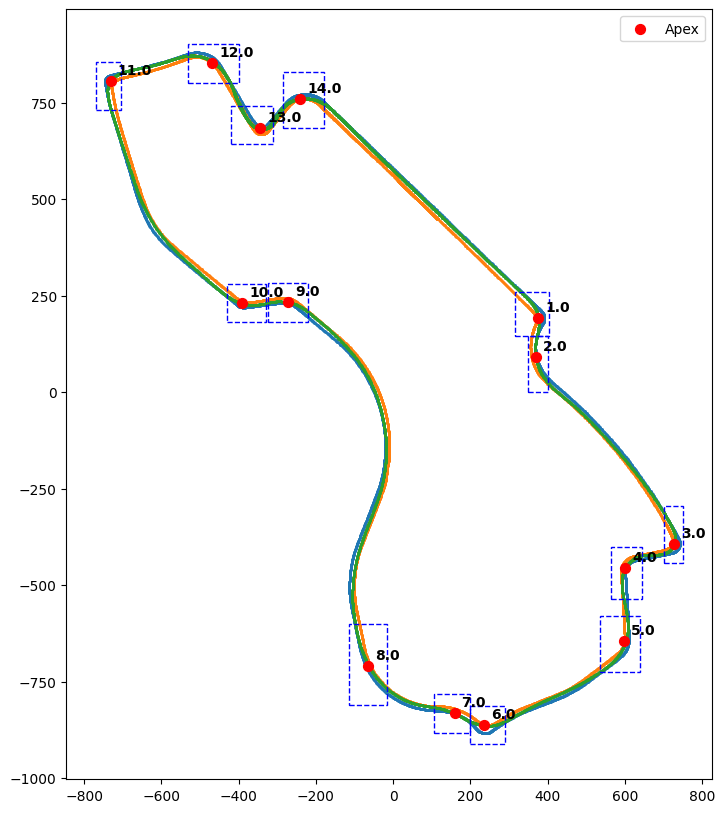

In [239]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(track_left["WORLDPOSX"], track_left["WORLDPOSY"], s=1)
ax.scatter(track_right["WORLDPOSX"], track_right["WORLDPOSY"], s=1)
ax.scatter(track_line["WORLDPOSX"], track_line["WORLDPOSY"], s=1)


# Plot apex dots
ax.scatter(turns["APEX_X1"], turns["APEX_Y1"], color="red", s=50, label="Apex")

# Draw boxes using corner coordinates
for _, row in turns.iterrows():
    x_min = min(row["CORNER_X1"], row["CORNER_X2"])
    x_max = max(row["CORNER_X1"], row["CORNER_X2"])
    y_min = min(row["CORNER_Y1"], row["CORNER_Y2"])
    y_max = max(row["CORNER_Y1"], row["CORNER_Y2"])

    # Rectangle patch
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False,
        color="blue",
        linestyle="--"
    )
    ax.add_patch(rect)
    
    ax.annotate(str(row["TURN"]),
                (row["APEX_X1"], row["APEX_Y1"]),
                textcoords="offset points", xytext=(5, 5),
                color="black", fontsize=10, weight="bold")

# Formatting
ax.set_aspect("equal", "box")
ax.legend()
plt.show()



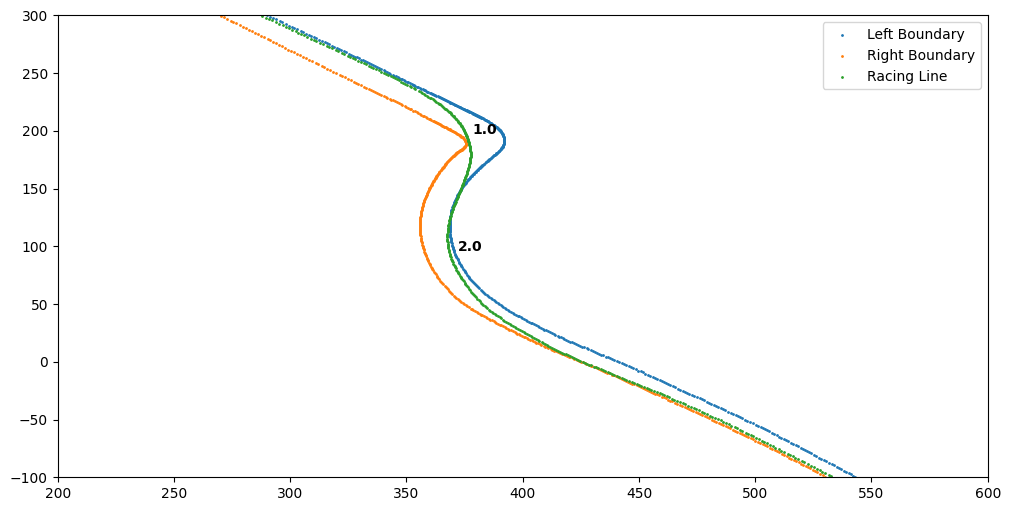

In [4]:
plt.figure(figsize=(12, 6))
plt.scatter(track_left["WORLDPOSX"], track_left["WORLDPOSY"], s=1, label="Left Boundary")
plt.scatter(track_right["WORLDPOSX"], track_right["WORLDPOSY"], s=1, label="Right Boundary")
plt.scatter(track_line["WORLDPOSX"], track_line["WORLDPOSY"], s=1, label="Racing Line")

plt.legend()

# Add turn annotations
for _, row in turns.iterrows():
    plt.annotate(str(row["TURN"]),
                (row["APEX_X1"], row["APEX_Y1"]),
                textcoords="offset points", xytext=(5, 5),
                color="black", fontsize=10, weight="bold")

# Set zoomed-in limits
plt.xlim(200, 600)  
plt.ylim(-100, 300)
plt.show()


In [5]:
data = pd.read_csv('data/UNSW F12024.csv')

C:\Users\samue\AppData\Local\Temp\ipykernel_34780\314155161.py:1: DtypeWarning: Columns (70,71,73,74,82) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/UNSW F12024.csv')


## Sectioning The data by Track
We only care about the Melbourne track

In [6]:
track0_data = data[data['M_TRACKID'] == 0]

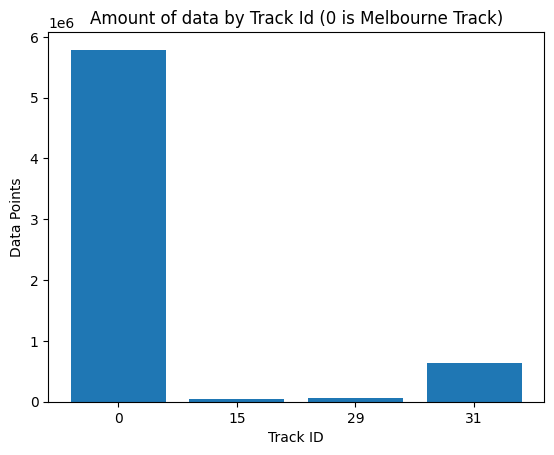

In [7]:
tracks = data.groupby("M_TRACKID").size()
plt.bar(x = tracks.index.astype(str), height = list(tracks.values))
plt.xlabel("Track ID")
plt.ylabel("Data Points")
plt.title("Amount of data by Track Id (0 is Melbourne Track)")
plt.show()

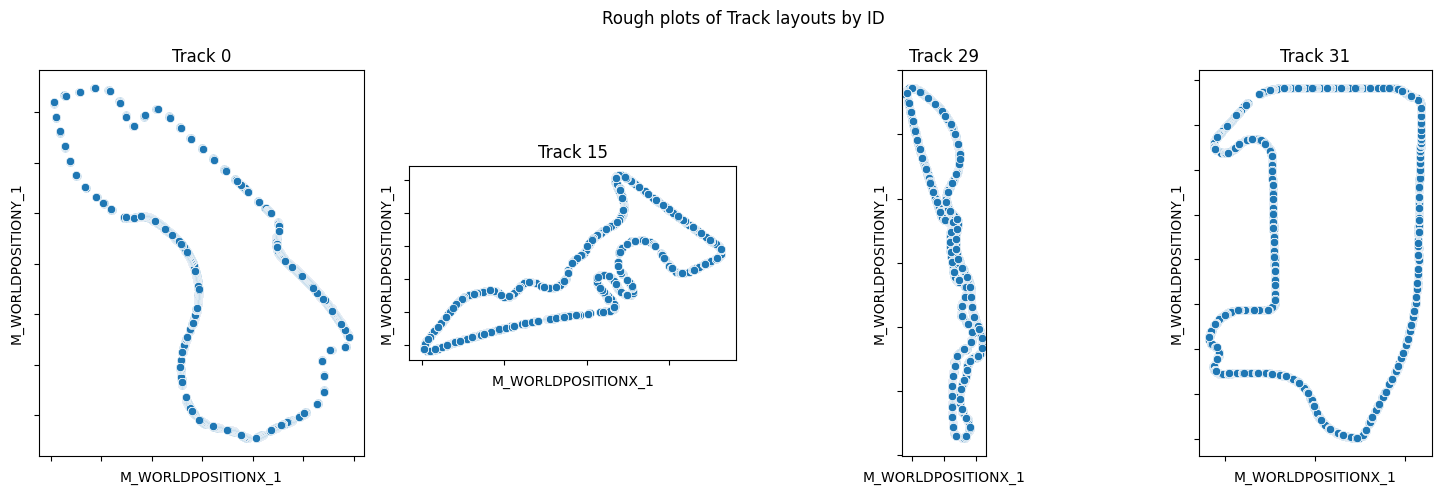

In [8]:
x_col="M_WORLDPOSITIONX_1" 
y_col="M_WORLDPOSITIONY_1"
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

track_ids = [0, 15, 29, 31]
for ax, tid in zip(axes, track_ids):
    if tid != 0:
        subset = data[data['M_TRACKID'] == tid].iloc[:5000]
    else: 
        subset = track0_data.iloc[:3000]
    sns.scatterplot(data=subset, x=x_col, y=y_col, ax=ax)
    ax.set_title(f"Track {tid}")
    ax.set_xticklabels([])  # hide x tick labels
    ax.set_yticklabels([])
    ax.set_aspect('equal', adjustable='box')

plt.suptitle("Rough plots of Track layouts by ID")
plt.tight_layout()
plt.show()

## Sectioning the Data by Distance
Keeping only the data from laps where distance is less than 1200 as we are not focused on the other corners

In [9]:
run_data = track0_data[track0_data['M_LAPDISTANCE_1'] <= 1200]

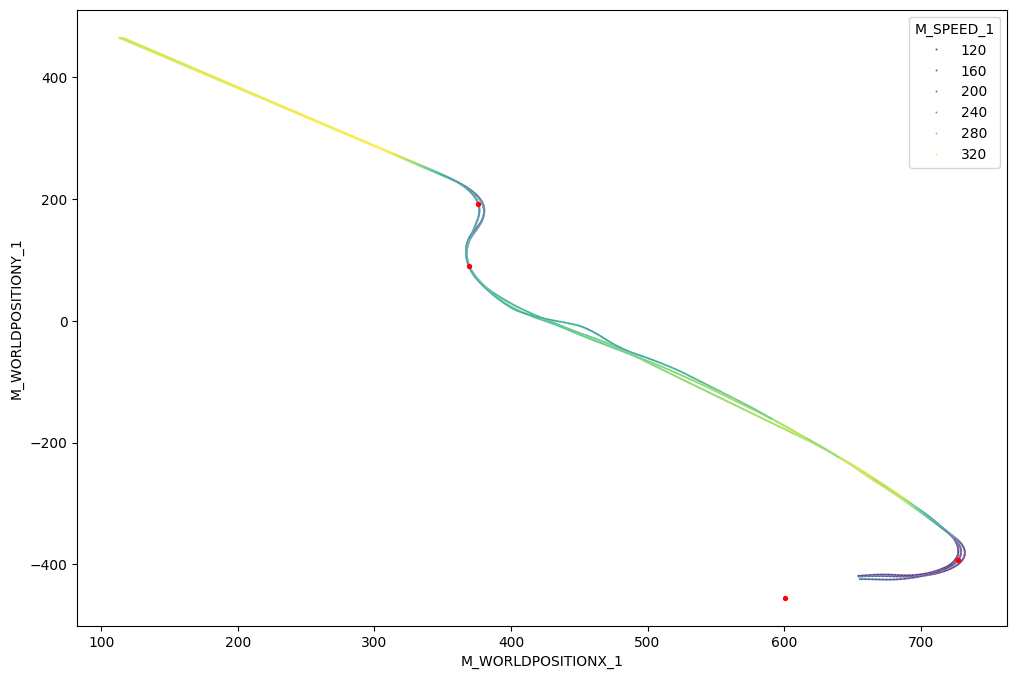

In [10]:
color_col="M_SPEED_1"

plt.figure(figsize=(12, 8))
sns.scatterplot(data=run_data[run_data["M_SESSIONUID"] == run_data.M_SESSIONUID.unique()[4]], x=x_col, y=y_col, hue=color_col, palette="viridis", s=2)
plt.scatter(turns["APEX_X1"][:4], turns["APEX_Y1"][:4], color="red", s=8, label="Apex")
plt.show()


# Track by rough distances

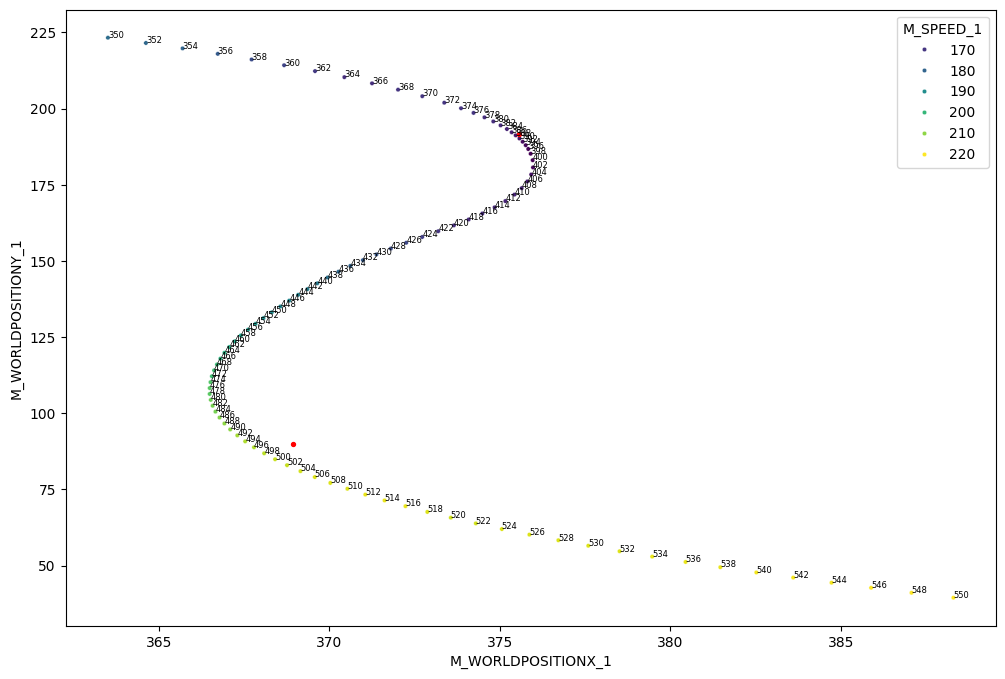

In [11]:
plt.figure(figsize=(12, 8))
sample = 2

plt_data = run_data[(run_data["M_SESSIONUID"] == run_data.M_SESSIONUID.unique()[2]) & (run_data["M_CURRENTLAPNUM"] == 1) & (
    run_data['M_LAPDISTANCE_1'] <= 550) & (run_data['M_LAPDISTANCE_1'] >= 350)].sort_values(by=["M_LAPDISTANCE_1"])

sns.scatterplot(data=plt_data.iloc[::sample], x=x_col,
                y=y_col, hue=color_col, palette="viridis", s=10)

for row in plt_data.iloc[::sample].itertuples():
    plt.text(getattr(row, x_col), getattr(row, y_col), str(
        getattr(row, "M_LAPDISTANCE_1")), fontsize=6)

plt.scatter(turns["APEX_X1"][:2], turns["APEX_Y1"]
            [:2], color="red", s=8, label="Apex")
plt.show()

# Lap time distributions

Lap time distributions

(If someone has time maybe look why some of the times on the >1 laps are 0)

In [12]:
percent = 75

lap_times = (
    run_data[run_data["M_LAPDISTANCE_1"] >= 1100]
    .groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"])["M_CURRENTLAPTIMEINMS_1"]
    .min()
)

lap_cutoff = np.percentile(lap_times, percent)
lap_fast = lap_times[lap_times <= lap_cutoff].reset_index()[["M_SESSIONUID","M_CURRENTLAPNUM"]]
lap_cut = run_data.merge(lap_fast, on=["M_SESSIONUID", "M_CURRENTLAPNUM"])

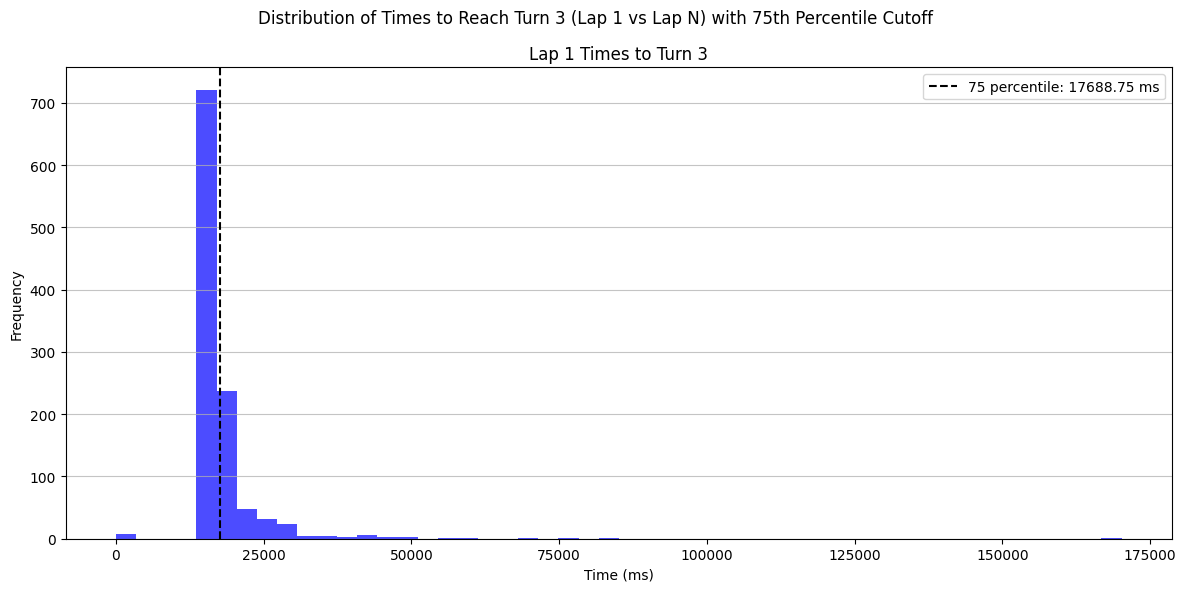

In [13]:
plt.figure(figsize=(12, 6))

plt.hist(lap_times, bins=50, color='blue', alpha=0.7)
plt.title("Lap 1 Times to Turn 3")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.axvline(lap_cutoff, color='black', linestyle='--', label=f'{percent} percentile: {lap_cutoff} ms')
plt.legend()

plt.suptitle(f"Distribution of Times to Reach Turn 3 (Lap 1 vs Lap N) with {percent}th Percentile Cutoff")
plt.tight_layout()
plt.show()

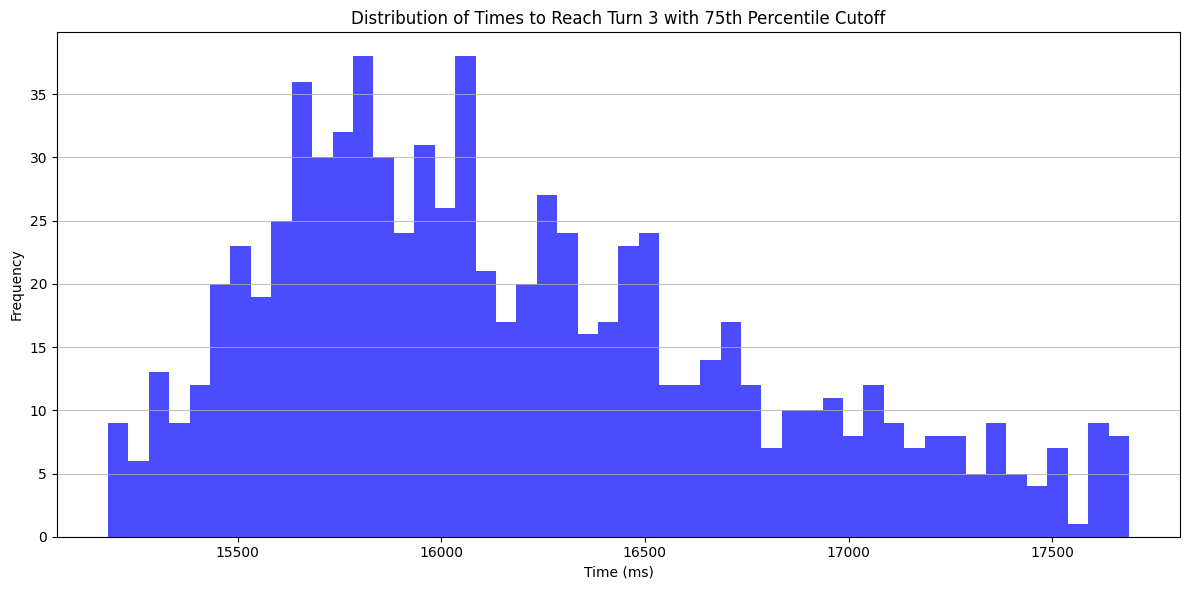

In [14]:
lap_times_cut = lap_times[(lap_times <= lap_cutoff) & (lap_times != 0)]
# lapn_cut = lapn_times[lapn_times <= lapn_cutoff]

plt.figure(figsize=(12, 6))
plt.hist(lap_times_cut, bins=50, color='blue', alpha=0.7)
# plt.title("Lap 1 Times to Turn 3 (Cut)")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.title(f"Distribution of Times to Reach Turn 3 with {percent}th Percentile Cutoff")
plt.tight_layout()
plt.show()


## Quesitons to ask (we should justify all for the report):
1. what percentile should we be using
2. should we be using std over percentile
3. should the percentile be n% of the combined or seperate
4. where to call the point to time do (currently 1100m)
5. if this is good / not good - I wont take any offence so dw, just looking for a good mark lol

# Turn to distance plot 

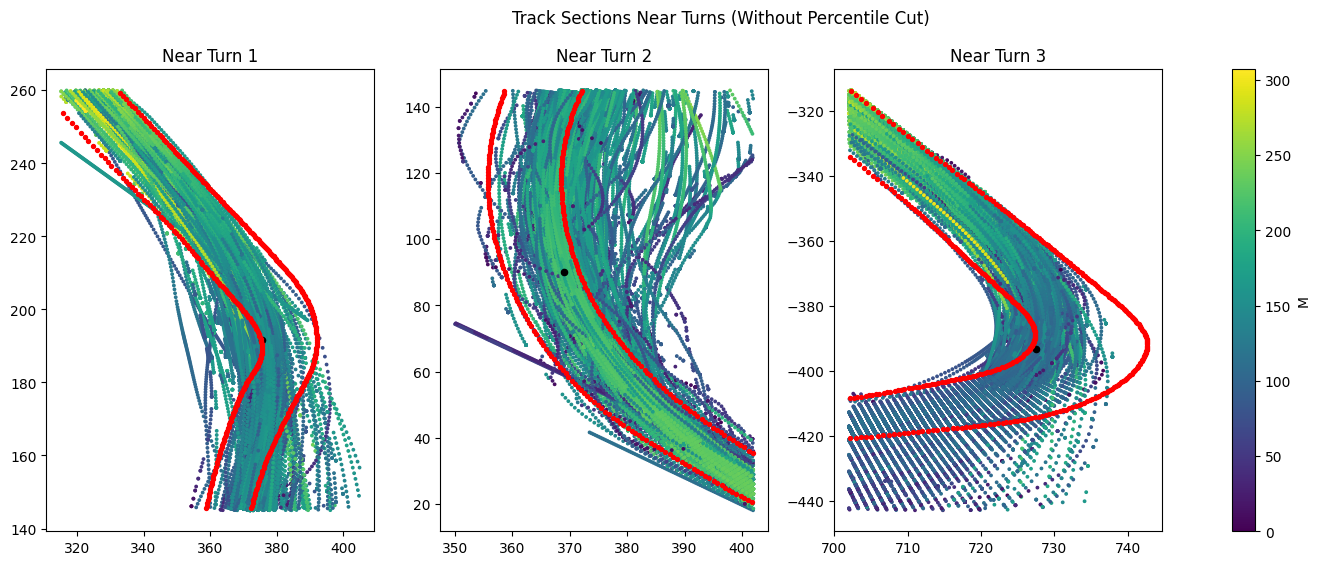

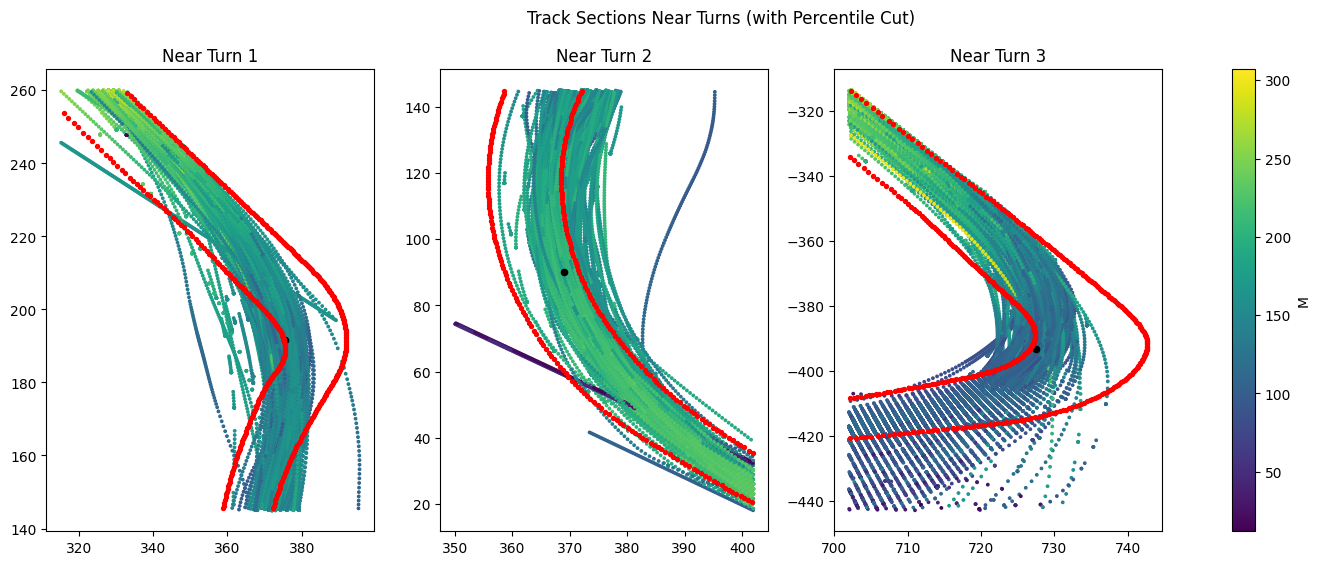

In [16]:
def plot_k_turns(data, turns, track_left, track_right, x_col="M_WORLDPOSITIONX_1", y_col="M_WORLDPOSITIONY_1", k=3, color_col="M_SPEED_1", title="Track Sections Near Turns", cmap = "viridis"):
    fig, axs = plt.subplots(1, k, figsize=(18, 6))

    for i in range(k):
        turn_n = turns.iloc[i]

        x_min = min(turn_n["CORNER_X1"], turn_n["CORNER_X2"])
        x_max = max(turn_n["CORNER_X1"], turn_n["CORNER_X2"])
        y_min = min(turn_n["CORNER_Y1"], turn_n["CORNER_Y2"])
        y_max = max(turn_n["CORNER_Y1"], turn_n["CORNER_Y2"])

        near_turn_n = data[(data[x_col] >= x_min) & (data[x_col] <= x_max) & 
                           (data[y_col] >= y_min) & (data[y_col] <= y_max)]

        tl_t2 = track_left[(track_left["WORLDPOSX"] >= x_min) & (track_left["WORLDPOSX"] <= x_max) & 
                           (track_left["WORLDPOSY"] >= y_min) & (track_left["WORLDPOSY"] <= y_max)]
        tr_t2 = track_right[(track_right["WORLDPOSX"] >= x_min) & (track_right["WORLDPOSX"] <= x_max) & 
                            (track_right["WORLDPOSY"] >= y_min) & (track_right["WORLDPOSY"] <= y_max)]

        scatter = axs[i].scatter(near_turn_n[x_col], near_turn_n[y_col], 
                                 c=near_turn_n[color_col[i] if type(color_col) == list else color_col], cmap=cmap, s=3)
        
        axs[i].scatter(turn_n["APEX_X1"], turn_n["APEX_Y1"], color="black", s=20, label="Apex")

        axs[i].scatter(tl_t2["WORLDPOSX"], tl_t2["WORLDPOSY"], s=8, color="red")
        axs[i].scatter(tr_t2["WORLDPOSX"], tr_t2["WORLDPOSY"], s=8, color="red")
        axs[i].set_title(f"Near Turn {i + 1}")

    fig.colorbar(scatter, ax=axs, orientation='vertical', label=color_col[0]) 
    plt.suptitle(title)
    plt.show()


plot_k_turns(run_data, turns, track_left, track_right, k=3, title=f"Track Sections Near Turns (Without Percentile Cut)")
plot_k_turns(lap_cut, turns, track_left, track_right, k=3, title=f"Track Sections Near Turns (with Percentile Cut)")

# Feature Enginerring

## Distance to apex

In [348]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def compute_distace_to_apex(data: pd.DataFrame, turns: pd.DataFrame):
    turn_1, turn_2 = turns[turns['TURN'] == 1], turns[turns['TURN'] == 2]
    apex_turn_1 = (turn_1['APEX_X1'].values[0], turn_1['APEX_Y1'].values[0])
    apex_turn_2 = (turn_2['APEX_X1'].values[0], turn_2['APEX_Y1'].values[0])

    data['dist_apex_1'] = euclidean_distance(
        (data[x_col], data[y_col]), # x1, y1
        (apex_turn_1[0], apex_turn_1[1]) # x2, y2
    )
    data['dist_apex_2'] = euclidean_distance(
        (data[x_col], data[y_col]), # x1, y1
        (apex_turn_2[0], apex_turn_2[1]) # x2, y2
    )
    return data

In [349]:
compute_distace_to_apex(lap_cut, turns).head(4)[["dist_apex_1", "dist_apex_2"]]

dist_apex_1  dist_apex_2
0   299.116905   376.259397
1   298.119090   375.291679
2   297.121262   374.324121
3   296.123444   373.356729

## Angle to apex
### Global angle 

In [19]:
def compute_angle_to_apex(data: pd.DataFrame, turns: pd.DataFrame):
    turn_1, turn_2 = turns[turns['TURN'] == 1], turns[turns['TURN'] == 2]
    apex_turn_1 = (turn_1['APEX_X1'].values[0], turn_1['APEX_Y1'].values[0])
    apex_turn_2 = (turn_2['APEX_X1'].values[0], turn_2['APEX_Y1'].values[0])

    df_new = data.copy()

    forward = df_new[['M_WORLDFORWARDDIRX_1', 'M_WORLDFORWARDDIRY_1']].to_numpy()
    pos = df_new[['M_WORLDPOSITIONX_1', 'M_WORLDPOSITIONY_1']].to_numpy()

    apex1_vec = np.array(apex_turn_1) - pos
    apex2_vec = np.array(apex_turn_2) - pos

    def angle_between(v1, v2):
        v1_u = v1 / np.linalg.norm(v1, axis=1, keepdims=True)
        v2_u = v2 / np.linalg.norm(v2, axis=1, keepdims=True)

        dot = np.clip(np.sum(v1_u * v2_u, axis=1), -1.0, 1.0)
        angle = np.arccos(dot)

        cross = v1_u[:,0]*v2_u[:,1] - v1_u[:,1]*v2_u[:,0]
        angle[cross < 0] = -angle[cross < 0]

        return np.degrees(angle)

    forward_rot = np.column_stack([-forward[:,1], forward[:,0]])
    df_new['angle_to_apex1'] = angle_between(forward_rot, apex1_vec)
    df_new['angle_to_apex2'] = angle_between(forward_rot, apex2_vec)

    return df_new

In [20]:
compute_angle_to_apex(lap_cut, turns).head(4)[["angle_to_apex1", "angle_to_apex2"]]

angle_to_apex1  angle_to_apex2
0       42.563474       31.217106
1       42.560506       31.186441
2       42.574453       31.172564
3       42.585913       31.156073

### Local Angle to Apex

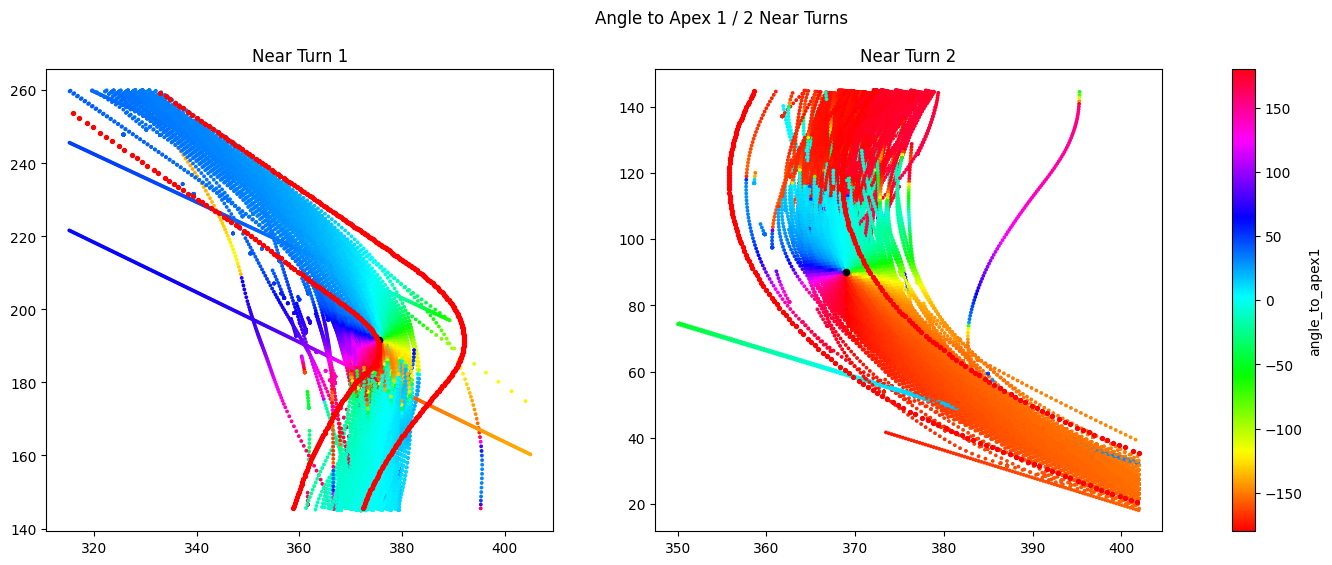

In [21]:
plot_k_turns(compute_angle_to_apex(lap_cut, turns), turns, track_left, track_right, k=2, color_col=["angle_to_apex1", "angle_to_apex2"], title=f"Angle to Apex 1 / 2 Near Turns", cmap="hsv")

## Track Width

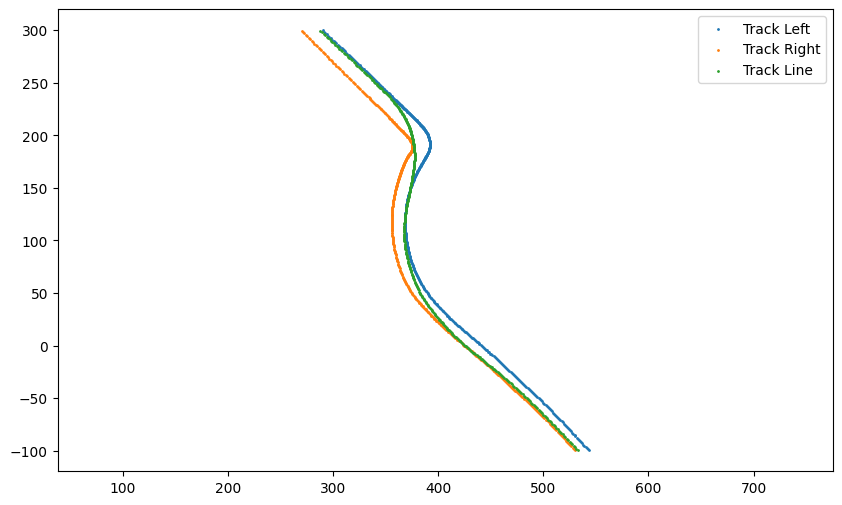

In [23]:
x_min, x_max = 200, 600
y_min, y_max = -100, 300

def clip_df(df, xcol="WORLDPOSX", ycol="WORLDPOSY"):
    return df[(df[xcol] >= x_min) & (df[xcol] <= x_max) &
              (df[ycol] >= y_min) & (df[ycol] <= y_max)]

track_left_clip = clip_df(track_left)
track_right_clip = clip_df(track_right)
track_line_clip = clip_df(track_line)

plt.figure(figsize=(10, 6))
plt.scatter(track_left_clip["WORLDPOSX"], track_left_clip["WORLDPOSY"], label="Track Left", s=1)
plt.scatter(track_right_clip["WORLDPOSX"], track_right_clip["WORLDPOSY"], label="Track Right", s=1)
plt.scatter(track_line_clip["WORLDPOSX"], track_line_clip["WORLDPOSY"], label="Track Line", s=1)

plt.legend()
plt.axis("equal")
plt.show()


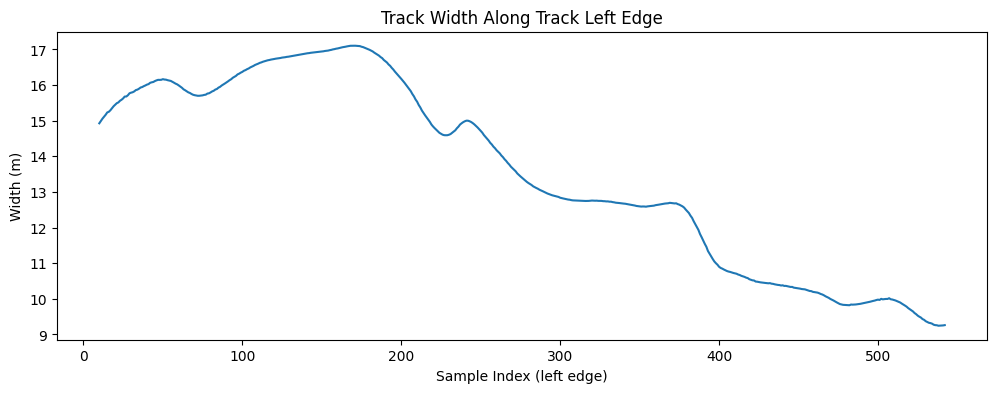

In [ ]:

# def compute_track_width(track_left: pd.DataFrame, track_right: pd.DataFrame) -> pd.DataFrame:
#     """
#     Compute track width by finding the closest point on the opposite edge.
    
#     Returns a DataFrame with left/right positions and track width.
#     """
#     # Build KDTree for fast nearest-neighbor search
#     right_points = np.vstack([track_right["WORLDPOSX"], track_right["WORLDPOSY"]]).T
#     tree = KDTree(right_points)

#     left_points = np.vstack([track_left["WORLDPOSX"], track_left["WORLDPOSY"]]).T

#     # For each left point, find closest right point
#     dists, idx = tree.query(left_points)

#     df = pd.DataFrame({
#         "left_x": track_left["WORLDPOSX"].values,
#         "left_y": track_left["WORLDPOSY"].values,
#         "right_x": track_right.iloc[idx]["WORLDPOSX"].values,
#         "right_y": track_right.iloc[idx]["WORLDPOSY"].values,
#         "left_frame": track_left.iloc[idx]["FRAME"].values,
#         "right_frame": track_right.iloc[idx]["FRAME"].values, 
#         "track_width": dists
#     })

#     return df
# track_widths = compute_track_width(track_left_clip.sort_values(by="FRAME"), track_right_clip.sort_values(by="FRAME"))

# plt.figure(figsize=(12,4))
# plt.plot(track_widths["track_width"][10:-10])
# plt.title("Track Width Along Track Left Edge")
# plt.xlabel("Sample Index (left edge)")
# plt.ylabel("Width (m)")
# plt.show()


## Distances 

In [124]:
run_data[[x_col, y_col]].isna().sum()

M_WORLDPOSITIONX_1    68301
M_WORLDPOSITIONY_1    68301
dtype: int64

In [125]:
run_data_filtered = run_data.dropna(subset=[x_col, y_col])

In [153]:
from tqdm.notebook import tqdm

In [ ]:


def two_closest_points(point, query_points: pd.DataFrame, x_col="WORLDPOSX", y_col="WORLDPOSY"):
    points = np.vstack([query_points[x_col], query_points[y_col]]).T
    tree = KDTree(points)
    dists, idxs = tree.query(point, k=2)
    return dists, query_points.iloc[idxs]

def projection_values(pointA: list, pointB1: list, pointB2: list):
    AB1 = [pointA[0] - pointB1[0], pointA[1] - pointB1[1]]
    B1B2 = [pointB2[0] - pointB1[0], pointB2[1] - pointB1[1]]
    
    # Check for division by zero
    distance_sq = euclidean_distance(pointB1, pointB2)**2
    if distance_sq < 1e-12:  # Points are essentially the same
        return {'d': euclidean_distance(pointA, pointB1), 'projA': pointB1, 'c': 0}
    
    # Projection scalar
    c = (AB1[0]*B1B2[0] + AB1[1]*B1B2[1]) / distance_sq
    projA = [pointB1[0] + c*B1B2[0], pointB1[1] + c*B1B2[1]]
    
    # Distance from A to its projection
    d = euclidean_distance(pointA, projA)
    
    return {'d': d, 'projA': projA, 'c': c}

def car_edge_distances(data, track_left, track_right, x_col="M_WORLDPOSITIONX_1", y_col="M_WORLDPOSITIONY_1"):
    ''' For each point in data, find the closest points on the left and right track edges.
    by:
    1. finding the two closest points on each
    2. projecting the point onto the line segment defined by those two points
    Returns a DataFrame with the same number of rows as input, including closest left/right edge points and distances.
    '''
    
    # Fix: Use correct column names for track edges
    left_points = np.vstack([track_left["WORLDPOSX"], track_left["WORLDPOSY"]]).T
    right_points = np.vstack([track_right["WORLDPOSX"], track_right["WORLDPOSY"]]).T
    
    left_tree = KDTree(left_points)
    right_tree = KDTree(right_points)

    df = data.copy()
    
    # Pre-allocate arrays for faster assignment
    left_dists = np.zeros(len(df))
    right_dists = np.zeros(len(df))
    
    # Extract car points as numpy array for faster access
    car_points = df[[x_col, y_col]].values
    
    for i in tqdm(range(len(df)), desc="Processing car positions"):
        car_point = car_points[i]
        
        # Find two closest points on track edges
        left_dist_vals, left_idxs = left_tree.query(car_point, k=2)
        right_dist_vals, right_idxs = right_tree.query(car_point, k=2)
        
        # Get left edge points
        left_p1 = left_points[left_idxs[0]]
        left_p2 = left_points[left_idxs[1]]
        left_proj = projection_values(car_point, left_p1, left_p2)

        # Get right edge points
        right_p1 = right_points[right_idxs[0]]
        right_p2 = right_points[right_idxs[1]]
        right_proj = projection_values(car_point, right_p1, right_p2)
        
        # Use projection distance if on segment, otherwise closest point distance
        if 0 <= left_proj['c'] <= 1:
            left_dists[i] = left_proj['d']
        else:
            left_dists[i] = left_dist_vals[0]
            
        if 0 <= right_proj['c'] <= 1:
            right_dists[i] = right_proj['d']
        else:
            right_dists[i] = right_dist_vals[0]
    
    # Assign all at once (faster than individual loc assignments)
    df["left_dist"] = left_dists
    df["right_dist"] = right_dists
    
    return df


def car_edge_distances(data, track_left, track_right, x_col="M_WORLDPOSITIONX_1", y_col="M_WORLDPOSITIONY_1"):
    ''' For each point in data, find the closest points on the left and right track edges.
    by:
    1. finding the two closest points on each
    2. projecting the point onto the line segment defined by those two points
    Returns a DataFrame with distances and track widths at the closest points.
    Assumes track_left and track_right have 'width' columns from calculate_track_width().
    '''
    
    # Fix: Use correct column names for track edges
    left_points = np.vstack([track_left["WORLDPOSX"], track_left["WORLDPOSY"]]).T
    right_points = np.vstack([track_right["WORLDPOSX"], track_right["WORLDPOSY"]]).T
    
    left_tree = KDTree(left_points)
    right_tree = KDTree(right_points)

    df = data.copy()
    
    # Pre-allocate arrays for faster assignment
    left_dists = np.zeros(len(df))
    right_dists = np.zeros(len(df))
    l_widths = np.zeros(len(df))
    r_widths = np.zeros(len(df))
    
    # Extract car points as numpy array for faster access
    car_points = df[[x_col, y_col]].values
    
    for i in tqdm(range(len(df)), desc="Processing car positions"):
        car_point = car_points[i]
        
        # Find two closest points on track edges
        left_dist_vals, left_idxs = left_tree.query(car_point, k=2)
        right_dist_vals, right_idxs = right_tree.query(car_point, k=2)
        
        # Get left edge points
        left_p1 = left_points[left_idxs[0]]
        left_p2 = left_points[left_idxs[1]]
        left_proj = projection_values(car_point, left_p1, left_p2)

        # Get right edge points
        right_p1 = right_points[right_idxs[0]]
        right_p2 = right_points[right_idxs[1]]
        right_proj = projection_values(car_point, right_p1, right_p2)
        
        # Use projection distance if on segment, otherwise closest point distance
        if 0 <= left_proj['c'] <= 1:
            left_dists[i] = left_proj['d']
            # Get width from closest point (first one)
            closest_left_idx = left_idxs[0]
        else:
            left_dists[i] = left_dist_vals[0]
            closest_left_idx = left_idxs[0]
            
        if 0 <= right_proj['c'] <= 1:
            right_dists[i] = right_proj['d']
            closest_right_idx = right_idxs[0]
        else:
            right_dists[i] = right_dist_vals[0]
            closest_right_idx = right_idxs[0]
        
        # Get track widths from the closest edge points
        l_widths[i] = track_left.iloc[closest_left_idx]['width']
        r_widths[i] = track_right.iloc[closest_right_idx]['width']
    
    # Assign all at once (faster than individual loc assignments)
    df["left_dist"] = left_dists
    df["right_dist"] = right_dists
    df["l_width"] = l_widths
    df["r_width"] = r_widths
    
    return df


def calculate_track_width(track_left, track_right):
    ''' For each point on track_left, calculate the width by projecting to the closest 2 points on track_right.
    Returns track_left and track_right DataFrames with added 'width' column.
    '''
    
    # Prepare points for KD tree
    left_points = np.vstack([track_left["WORLDPOSX"], track_left["WORLDPOSY"]]).T
    right_points = np.vstack([track_right["WORLDPOSX"], track_right["WORLDPOSY"]]).T
    
    left_tree = KDTree(left_points)
    right_tree = KDTree(right_points)
    
    # Calculate width for left edge points
    left_df = track_left.copy()
    left_widths = np.zeros(len(left_df))
    
    for i in tqdm(range(len(left_df)), desc="Calculating left edge widths"):
        left_point = left_points[i]
        
        # Find two closest points on right edge
        right_dist_vals, right_idxs = right_tree.query(left_point, k=2)
        
        # Get right edge points
        right_p1 = right_points[right_idxs[0]]
        right_p2 = right_points[right_idxs[1]]
        right_proj = projection_values(left_point, right_p1, right_p2)
        
        # Use projection distance if on segment, otherwise closest point distance
        if 0 <= right_proj['c'] <= 1:
            left_widths[i] = right_proj['d']
        else:
            left_widths[i] = right_dist_vals[0]
    
    left_df["width"] = left_widths
    
    # Calculate width for right edge points
    right_df = track_right.copy()
    right_widths = np.zeros(len(right_df))
    
    for i in tqdm(range(len(right_df)), desc="Calculating right edge widths"):
        right_point = right_points[i]
        
        # Find two closest points on left edge
        left_dist_vals, left_idxs = left_tree.query(right_point, k=2)
        
        # Get left edge points
        left_p1 = left_points[left_idxs[0]]
        left_p2 = left_points[left_idxs[1]]
        left_proj = projection_values(right_point, left_p1, left_p2)
        
        # Use projection distance if on segment, otherwise closest point distance
        if 0 <= left_proj['c'] <= 1:
            right_widths[i] = left_proj['d']
        else:
            right_widths[i] = left_dist_vals[0]
    
    right_df["width"] = right_widths
    
    return left_df, right_df

In [173]:
# First calculate track widths
left_with_width, right_with_width = calculate_track_width(track_left.sort_values(by="FRAME").reset_index(), track_right.sort_values(by="FRAME").reset_index())

# Then get car distances and local track widths
result_df = car_edge_distances(run_data_filtered, left_with_width, right_with_width)

# Now you have all the information
print(result_df[['left_dist', 'right_dist', 'l_width', 'r_width']].head())

Calculating left edge widths:   0%|          | 0/5416 [00:00<?, ?it/s]

Calculating right edge widths:   0%|          | 0/5766 [00:00<?, ?it/s]

Processing car positions:   0%|          | 0/1246720 [00:00<?, ?it/s]

   left_dist  right_dist    l_width    r_width
0   2.119045   11.141234  13.261554  13.260272
1   2.119052   11.144147  13.261554  13.260272
2   2.118991   11.147151  13.267978  13.267137
3   2.119299   11.150750  13.273649  13.267137
4   2.119722   11.154651  13.273649  13.274641


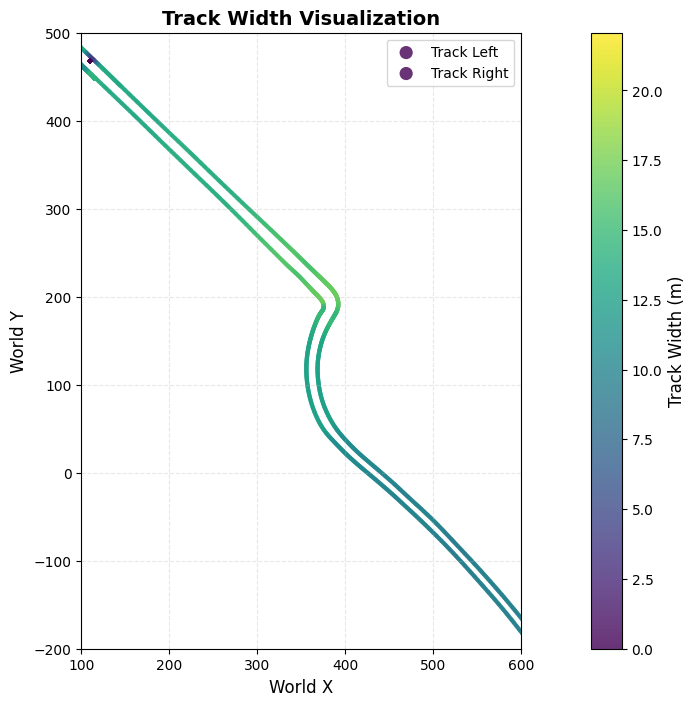

In [245]:
plt.figure(figsize=(18, 8))

# left edge
plt.scatter(
    left_with_width["WORLDPOSX"], left_with_width["WORLDPOSY"],
    c=left_with_width["width"], cmap="viridis",
    s=10, edgecolor="none", alpha=0.8, label="Track Left"
)

# right edge
plt.scatter(
    right_with_width["WORLDPOSX"], right_with_width["WORLDPOSY"],
    c=right_with_width["width"], cmap="viridis",
    s=10, edgecolor="none", alpha=0.8, label="Track Right"
)

# colorbar for width
cbar = plt.colorbar()
cbar.set_label("Track Width (m)", fontsize=12)

# aesthetics
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("World X", fontsize=12)
plt.ylabel("World Y", fontsize=12)
plt.title("Track Width Visualization", fontsize=14, weight="bold")
plt.legend(markerscale=3, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")

plt.xlim(100, 600)
plt.ylim(-200, 500)
plt.show()


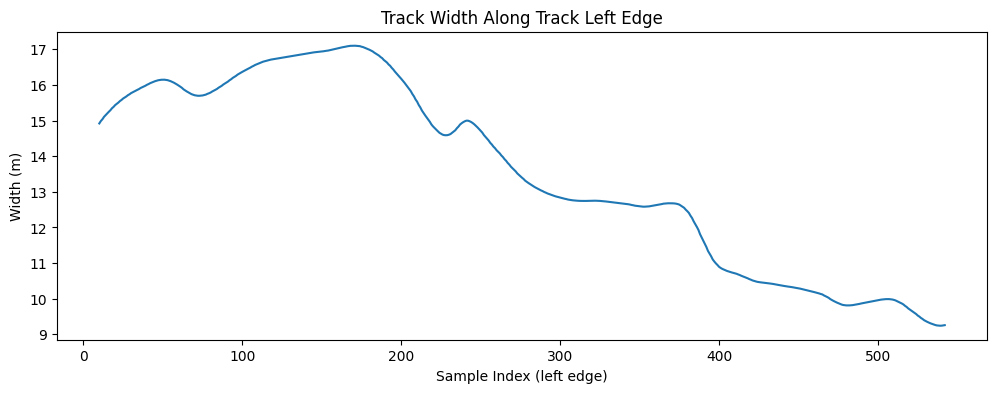

In [231]:
plt.figure(figsize=(12,4))
plt.plot(l["width"][10:-10])
plt.title("Track Width Along Track Left Edge")
plt.xlabel("Sample Index (left edge)")
plt.ylabel("Width (m)")
plt.show()

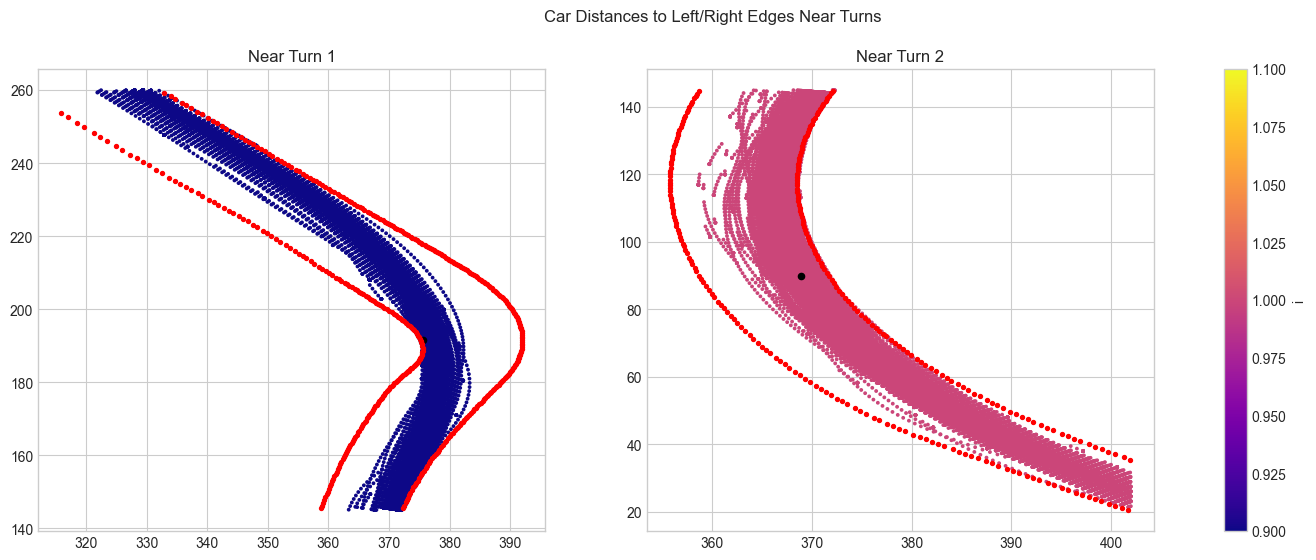

In [283]:
result_df["in"] = (result_df["left_dist"] + result_df["right_dist"]) < (result_df["l_width"] + result_df["r_width"])/2 + 0.53
result_df_800m = result_df[(result_df["M_LAPDISTANCE_1"] <= 800) & (result_df["M_LAPDISTANCE_1"] >= 50)]
result_df_filterd = result_df_800m.groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"]).filter(lambda grp: grp["in"].all())
plot_k_turns(result_df_filterd, turns, left_with_width, right_with_width, k=2, color_col="in", title=f"Car Distances to Left/Right Edges Near Turns", cmap="plasma")

In [284]:
len(result_df_filterd.groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"]))

395

In [285]:
len(result_df_800m.groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"]))

1045

## testing car width

In [312]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use("seaborn-v0_8-whitegrid")  # clean professional style

buffers = np.linspace(0.1, 1.5, 15*15)

df = result_df[result_df["M_LAPDISTANCE_1"].between(50, 800)]

metrics = []

for buf in tqdm(buffers):
    in_track = (df["left_dist"] + df["right_dist"]) < \
               (df["l_width"] + df["r_width"]) / 2 + buf

    pred_invalid = (
        df.assign(in_track=in_track)
        .groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"])["in_track"]
        .all()
        .apply(lambda x: 0 if x else 1)  # 1 = invalid
    )

    true_invalid = (
        df.groupby(["M_SESSIONUID", "M_CURRENTLAPNUM"])["M_CURRENTLAPINVALID_1"]
        .first()
    )

    y_true = true_invalid.values
    y_pred = pred_invalid.values

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    f1 = f1_score(y_true, y_pred)

    metrics.append((buf, f1, tp, fp, tn, fn))

  0%|          | 0/225 [00:00<?, ?it/s]

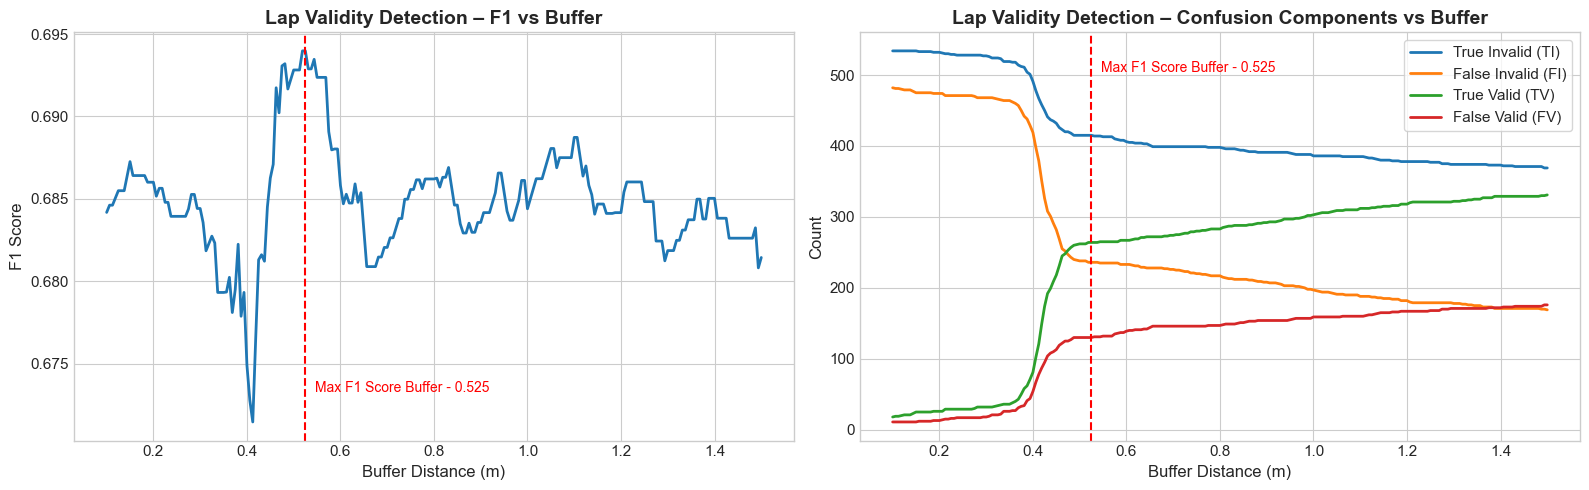

In [346]:
metrics = np.array(metrics, dtype=float)
fig, axs = plt.subplots(1, 2, figsize=(16,5))



best_buffer = metrics[:,0][np.argmax(metrics[:,1]) + 1] 
# --- Plot F1 Score ---

axs[0].plot(metrics[:,0], metrics[:,1], color="C0", linewidth=2)
axs[0].set_xlabel("Buffer Distance (m)", fontsize=12)
axs[0].set_ylabel("F1 Score", fontsize=12)
axs[0].set_title("Lap Validity Detection – F1 vs Buffer", fontsize=14, weight="bold")
axs[0].tick_params(axis="both", labelsize=11)
axs[0].axvline(x=best_buffer, color='r', linestyle='--', label='Vertical Line')
axs[0].text(best_buffer+0.02, axs[0].get_ylim()[0]*0.9 + 0.07, f'Max F1 Score Buffer - {best_buffer}', color='red')
# plt.tight_layout()
# plt.show()

# --- Plot Confusion Components ---
# fig, ax = plt.subplots(figsize=(9,6))
axs[1].plot(metrics[:,0], metrics[:,2], label="True Invalid (TI)", linewidth=2)   # TP
axs[1].plot(metrics[:,0], metrics[:,3], label="False Invalid (FI)", linewidth=2)  # FP
axs[1].plot(metrics[:,0], metrics[:,4], label="True Valid (TV)", linewidth=2)     # TN
axs[1].plot(metrics[:,0], metrics[:,5], label="False Valid (FV)", linewidth=2)    # FN

axs[1].set_xlabel("Buffer Distance (m)", fontsize=12)
axs[1].set_ylabel("Count", fontsize=12)
axs[1].set_title("Lap Validity Detection – Confusion Components vs Buffer", fontsize=14, weight="bold")
axs[1].legend(fontsize=11, frameon=True)
axs[1].tick_params(axis="both", labelsize=11)
axs[1].axvline(x=best_buffer, color='r', linestyle='--', label='Vertical Line')
axs[1].text(best_buffer+0.02, axs[1].get_ylim()[1]*0.9, f'Max F1 Score Buffer - {best_buffer}', color='red')
fig.tight_layout()
plt.show()


## Other

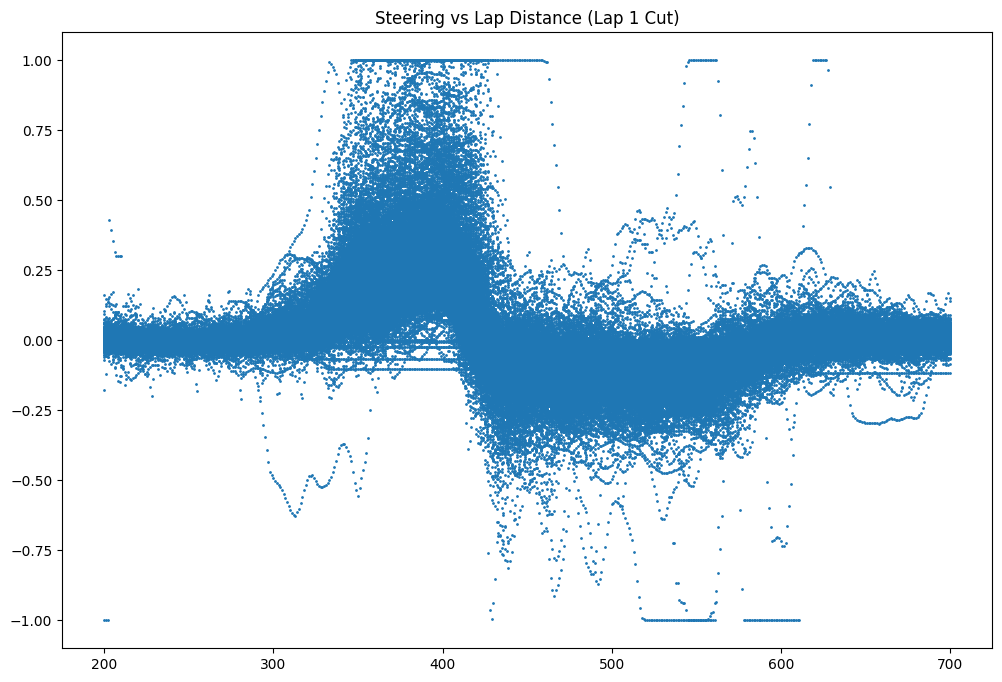

In [51]:
plt.figure(figsize=(12, 8))
a = lap_cut[(lap_cut["M_LAPDISTANCE_1"] >= 200) & (lap_cut["M_LAPDISTANCE_1"] <= 700)]
plt.scatter(x = a["M_LAPDISTANCE_1"], y = a["M_STEER_1"], s = 1)
plt.title("Steering vs Lap Distance (Lap 1 Cut)")
plt.show()

In [48]:
print(f"Total laps: {len(lap_cut[['M_SESSIONUID', 'M_CURRENTLAPNUM']].drop_duplicates())}")


Total laps: 823


# Testing Files

In [364]:
from cleaning_functions import remove_other_tracks, remove_na, car_edge_distances, calculate_track_width
from functions import load_race_data, load_entire_track, filter_by_distance

In [363]:
import cleaning_functions as cf
import functions as fn

from importlib import reload
reload(cf)
reload(fn)

<module 'functions' from 'c:\\Users\\samue\\Projects\\Data3001\\functions.py'>